# How to use pySTARE.
Here we'll work with a basic polygon formed from a series of (lat, lon) coordinate-pairs and use the `pySTARE` numpy-based API to access the `STARE` toolkit.

In [1]:
# Standard Imports

# Third-Party Imports
import numpy as np
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# STARE Imports
import pystare
# ------------------------------------------------------------------------------

LON_180 = lambda x: ((x + 180.0) % 360.0) - 180.0
LON_360 = lambda x: ((x + 360.0) % 360.0)

##
# Example Polygon Vertices
geo_lons_180 = [-5.0, -5.0, 20.0, 20.0]
geo_lats = [68.0, 56.0, 56.0, 68.0]

Next we can form a Shapely polygon and make a basic plot using it.

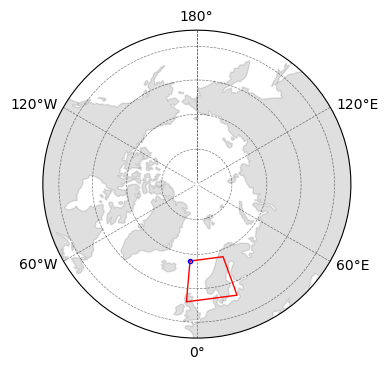

In [2]:
##
# Form polygon (refered to as Polygon-A)
verts_180 = [(float(geo_lons_180[_]), float(geo_lats[_])) for _ in range(len(geo_lons_180))]
poly_180 = Polygon(verts_180)

##
# Make Figure
# --------------------------------------------------------------------------
map_extent = [-180, 180, 45, 90]
lon_0_global = 0.0

# WGS-84 Earth equatorial radius at sea level (meters)
globe = ccrs.Globe(datum='WGS84', ellipse='WGS84')

# Geodetic:
#   A 3D/spherical CRS based on latitude and longitude where geographical distance and coordinates are measured in degrees.
geod_crs = ccrs.Geodetic(globe=globe)

# PlateCarree Projection (AKA Equirectangular or Equidistant Cylindrical):
#   A 2D CRS with a flat topology and Euclidean distance (m).
flat_crs = ccrs.PlateCarree(central_longitude=lon_0_global, globe=globe)

# Lambert Azimuthal Equal-Area
#   A 2D CRS centered on (map_lat0, map_lon0), which is then the zero point of the flat topology w/ Euclidean distance (m).
polar_crs = ccrs.LambertAzimuthalEqualArea(central_longitude=lon_0_global, central_latitude=90.0)

fig = plt.figure(figsize=(12, 4), frameon=True)
geo_axes = plt.axes(projection=polar_crs)
geo_axes.set_extent(map_extent, flat_crs)
geo_axes.add_feature(cfeature.LAND, color='grey', alpha=0.25)
gl = geo_axes.gridlines(draw_labels=True, linewidth=.5, color='k', alpha=0.5, linestyle='--')
geo_axes.plot(*poly_180.exterior.xy, 'r-', linewidth=1, markersize=1, transform=geod_crs)
geo_axes.plot(verts_180[0][0], verts_180[0][1], 'bo', markersize=3, mfc='none', linewidth=.25, transform=geod_crs)

# Trim plot
theta = np.linspace(0.0, 2.0 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
geo_axes.set_boundary(circle, transform=geo_axes.transAxes)

plt.show()

Now, we can work with `STARE`. To start, we will use `pySTARE` to calculate the `STARE` indices ('SIDs') for our polygon. To do this we need to select a `STARE` encoding level, which is basically related to the scale-length of the resulting trixel edges.

    STARE Encoding Levels (Q)

    Q-00 ~Length Scale: 10240 km      Q-14  ~Length Scale:        0.625 km
    Q-01 ~Length Scale:  5120 km      Q-15  ~Length Scale:       0.3125 km
    Q-02 ~Length Scale:  2560 km      Q-16  ~Length Scale:      0.15625 km
    Q-03 ~Length Scale:  1280 km      Q-17  ~Length Scale:     0.078125 km
    Q-04 ~Length Scale:   640 km      Q-18  ~Length Scale:    0.0390625 km
    Q-05 ~Length Scale:   320 km      Q-19  ~Length Scale:    0.0195312 km
    Q-06 ~Length Scale:   160 km      Q-20  ~Length Scale:   0.00976562 km
    Q-07 ~Length Scale:    80 km      Q-21  ~Length Scale:   0.00488281 km
    Q-08 ~Length Scale:    40 km      Q-22  ~Length Scale:   0.00244141 km
    Q-09 ~Length Scale:    20 km      Q-23  ~Length Scale:    0.0012207 km
    Q-10 ~Length Scale:    10 km      Q-24  ~Length Scale:  0.000610352 km
    Q-11 ~Length Scale:     5 km      Q-25  ~Length Scale:  0.000305176 km
    Q-12 ~Length Scale:   2.5 km      Q-26  ~Length Scale:  0.000152588 km
    Q-13 ~Length Scale:  1.25 km      Q-27  ~Length Scale:  7.62939E-05 km

Examination of our polygon suggests a level around Q-10 (10 km) might be sufficient. We'll show even higher levels just for fun.

In [3]:
##
# Find STARE Indices (SIDs) for the polygon () vertices using pystare
q_level = 10
sids = pystare.from_latlon(geo_lats, geo_lons_180, q_level)
print(f"Q-{q_level:02d} Poly-A SIDs ({len(sids)}): {sids.tolist()}")

q_level = 14
sids14 = pystare.from_latlon(geo_lats, geo_lons_180, q_level)
print(f"Q-{q_level:02d} Poly-A SIDs ({len(sids14)}): {sids14.tolist()}")

q_level = 27
sids27 = pystare.from_latlon(geo_lats, geo_lons_180, q_level)
print(f"Q-{q_level:02d} Poly-A SIDs ({len(sids27)}): {sids27.tolist()}")

Q-10 Poly-A SIDs (4): [3674107313343784874, 4268920612326221354, 4252901238457901354, 3896511777288345930]
Q-14 Poly-A SIDs (4): [3674107313343784878, 4268920612326221358, 4252901238457901358, 3896511777288345934]
Q-27 Poly-A SIDs (4): [3674107313343784891, 4268920612326221371, 4252901238457901371, 3896511777288345947]


This results in four SIDs, which are formatted 64-bit integers. For comparison, we can use higher Q-levels to get a different set of found 64-bit integers, although because of the simple shape our polygon some of them are exactly the same (i.e., no benefit of smaller scale-length).

Next we ask `pySTARE` to treat our vertices as a polygon, specifically a convex hull, with edges and an interior.

In [4]:
q_level = 10
hull_sids = pystare.cover_from_hull(geo_lats, geo_lons_180, q_level)
print(f"Q-{q_level:02d} Hull SIDs ({len(hull_sids)}): [{hull_sids[0]}, {hull_sids[1]}, ... {hull_sids[-1]}] ")

q_level = 14
hull_sids14 = pystare.cover_from_hull(geo_lats, geo_lons_180, q_level)
print(f"Q-{q_level:02d} Hull SIDs ({len(hull_sids14)}): [{hull_sids14[0]}, {hull_sids14[1]}, ... {hull_sids14[-1]}] ")

# q_level = 27
# hull_sids27 = pystare.cover_from_hull(geo_lats, geo_lons_180, q_level)
# print(f"Q-{q_level:02d} Hull SIDs ({len(hull_sids27)}): [{hull_sids27[0]}, {hull_sids27[1]}, ... {hull_sids27[-1]}] ")

Q-10 Hull SIDs (1975): [3643412098542731268, 3659174697238528004, ... 4285042554291879946] 
Q-14 Hull SIDs (33022): [3643412098542731268, 3659174697238528004, ... 4285042992378544142] 


As expected, if told to treat the vertices as separate points, `pySTARE` returns four SIDs, and if treated as a convex hull we get 1975 SIDs (at Q-level 10). Note the compute time is much longer for the convex hull, as it has to calculate the SIDs for all the edges and interior of the polygon. The time difference is not a problem for our simple polygon (less than a second to 1.3s), but this could become more much substantial for more complex polygons or at higher Q-levels (here from 1.3s for Q-14 to over 20m for Q-27, hence it being commented out). 

Anyway, the above code works because our simple polygon conforms to a convex hull geometry. If this was not the case, or even if it is, we can ask `pySTARE` to treat our vertices as a generic closed polygon instead.

In [5]:
q_level = 10
ring_sids = pystare.cover_from_ring(geo_lats, geo_lons_180, q_level)
print(f"Q-{q_level:02d} Ring SIDs ({len(ring_sids)}): [{ring_sids[0]}, {ring_sids[1]}, ... {ring_sids[-1]}] ")

q_level = 14
ring_sids14 = pystare.cover_from_ring(geo_lats, geo_lons_180, q_level)
print(f"Q-{q_level:02d} Ring SIDs ({len(ring_sids14)}): [{ring_sids14[0]}, {ring_sids14[1]}, ... {ring_sids14[-1]}] ")

Q-10 Ring SIDs (1975): [3643412098542731268, 3659174697238528004, ... 4285042554291879946] 
Q-14 Ring SIDs (33022): [3643412098542731268, 3659174697238528004, ... 4285042992378544142] 


In our case this gives the same result. The reason to use `pystare.cover_from_hull` over the more generic `pystare.cover_from_ring` when your polygon is well suited for a convex hull is that `pystare.cover_from_hull` is much faster (here ~3x).

Another common use of `STARE` is for preforming set operations between sets of SIDs (e.g., union or intersection). For this purpose we will create two additional sets of vertices.

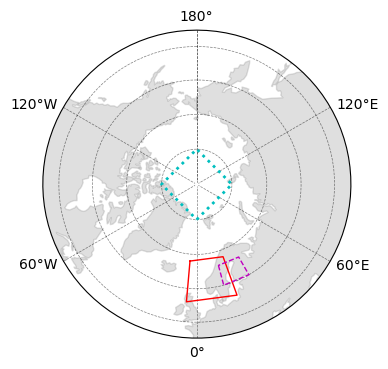

In [6]:
geob_lons_180 = [15.0, 15.0, 30.0, 30.0]
geob_lats = [66.0, 60.0, 60.0, 66.0]
vertsb_180 = [(float(geob_lons_180[_]), float(geob_lats[_])) for _ in range(len(geob_lons_180))]
polyb_180 = Polygon(vertsb_180)

geoc_lons_180 = [0.0, 90.0, 180.0, -90.0]
geoc_lats = [80.0, 80.0, 80.0, 80.0]
vertsc_180 = [(float(geoc_lons_180[_]), float(geoc_lats[_])) for _ in range(len(geoc_lons_180))]
polyc_180 = Polygon(vertsc_180)

fig = plt.figure(figsize=(12, 4), frameon=True)
geo_axes = plt.axes(projection=polar_crs)
geo_axes.set_extent(map_extent, flat_crs)
geo_axes.add_feature(cfeature.LAND, color='grey', alpha=0.25)
gl = geo_axes.gridlines(draw_labels=True, linewidth=.5, color='k', alpha=0.5, linestyle='--')
geo_axes.plot(*poly_180.exterior.xy, 'r-', linewidth=1, markersize=1, transform=geod_crs)
geo_axes.plot(*polyb_180.exterior.xy, 'm--', linewidth=1, markersize=1, transform=geod_crs)
geo_axes.plot(*polyc_180.exterior.xy, 'c:', linewidth=2, markersize=1, transform=geod_crs)

# Trim plot
theta = np.linspace(0.0, 2.0 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
geo_axes.set_boundary(circle, transform=geo_axes.transAxes)

plt.show()

As before we can calculate the convex hull SIDs for each of these (poly-B uses magenta dashed-lines and poly-C uses cyan dotted-lines).

In [7]:
q_level = 10
hull_sidsb = pystare.cover_from_hull(geob_lats, geob_lons_180, q_level)
print(f"Q-{q_level:02d} Hull SIDs B ({len(hull_sidsb)}): [{hull_sidsb[0]}, {hull_sidsb[1]}, ... {hull_sidsb[-1]}] ")

hull_sidsc = pystare.cover_from_hull(geoc_lats, geoc_lons_180, q_level)
print(f"Q-{q_level:02d} Hull SIDs C ({len(hull_sidsc)}): [{hull_sidsc[0]}, {hull_sidsc[1]}, ... {hull_sidsc[-1]}] ")

Q-10 Hull SIDs B (1037): [3639471448868782085, 3646789798263259141, ... 3898990827640193034] 
Q-10 Hull SIDs C (1451): [4014959067800797188, 3910250376464433157, ... 4034097167193866250] 


With these, we can easily check for intersections between these shapes.

<img width="40%" alt="intersection.png" src="intersection.png" style="border-radius: 15%">(Example of the intersection (green) of two sets of trixels (blue and red))


In [8]:
q_level = 10

##
# Check Polygon-B intersect with our original Polygon-A
try_intersectab = pystare.intersects(hull_sids, hull_sidsb)
does_intersectab = np.count_nonzero(try_intersectab)
print(f"Q-{q_level:02d} Hull-A intersects Hull-B: {does_intersectab}")

##
# Check Polygon-C intersect with our original Polygon-A
try_intersectac = pystare.intersects(hull_sids, hull_sidsc)
does_intersectac = np.count_nonzero(try_intersectac)
print(f"Q-{q_level:02d} Hull-A intersects Hull-C: {does_intersectac}")

##
# Check Polygon-B intersect with Polygon-C
try_intersectbc = pystare.intersects(hull_sidsb, hull_sidsc)
does_intersectbc = np.count_nonzero(try_intersectbc)
print(f"Q-{q_level:02d} Hull-B intersects Hull-C: {does_intersectbc}")

Q-10 Hull-A intersects Hull-B: 461
Q-10 Hull-A intersects Hull-C: 0
Q-10 Hull-B intersects Hull-C: 0


From this, we see that there are 461 Q-10 SIDs in common between our original polygon (A) and polygon-B, and no intersections with either and polygon-C.  

**Author:** [Mike Bauer](mbauer@bayesics.com)

**Last update:** 03-April-2025 (Created: 03-April-2025)